In [1]:
%cd "/workspace/src"

/workspace/src


In [2]:
from cvl.dataset import OnlineTrackingBenchmark
from mosse import MOSSETrackerGrayscale
from multi_channel_mosse import MOSSEMultiChannel
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import norm
from cvl.image_io import crop_patch
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [3]:
dataset_path = "../data/Mini-OTB"
dataset = OnlineTrackingBenchmark(dataset_path)
SEQUENCE_IDX = 5
a_seq = iter(dataset[SEQUENCE_IDX])
first_frame = next(a_seq)
frame_idx = 1

In [4]:
std = 5
learning_rate = 0.05
BBOX_ENLARGE_FACTOR = 3.0
tracker = MOSSETrackerGrayscale(std=std, learning_rate=learning_rate)

In [5]:
image = np.sum(first_frame["image"], 2) / 3
bbox = first_frame["bounding_box"]
bbox.__dict__

{'xpos': 478, 'ypos': 143, 'width': 80, 'height': 111}

In [6]:
bbox.xpos -= int(bbox.width * (BBOX_ENLARGE_FACTOR - 1) / 2)
bbox.width = int(bbox.width * BBOX_ENLARGE_FACTOR)
bbox.ypos -= int(bbox.height * (BBOX_ENLARGE_FACTOR - 1) / 2)
bbox.height = int(bbox.height * BBOX_ENLARGE_FACTOR)
if bbox.width % 2 == 0:
    bbox.width += 1

if bbox.height % 2 == 0:
    bbox.height += 1

In [7]:
bbox.__dict__

{'xpos': 398, 'ypos': 32, 'width': 241, 'height': 333}

## Start

In [19]:
# Where the gaussian should be centered
region = bbox
region_center = (region.height // 2, region.width // 2)

C = MOSSETrackerGrayscale.get_fourier_transformed_gaussian(height=region.height, width=region.width, std=std,
                                   mean_x=0, mean_y=0)

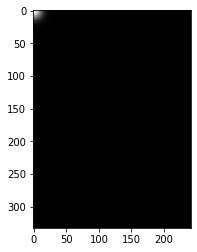

In [20]:
plt.imshow(np.abs(C), cmap="gray")

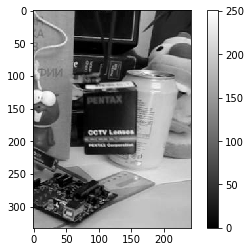

In [21]:
patch = crop_patch(image, region)
plt.imshow(patch, cmap="gray")
plt.colorbar()

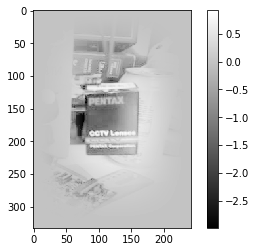

In [11]:
normalized_patch = MOSSETrackerGrayscale.normalize(patch)
plt.imshow(normalized_patch, cmap="gray")
plt.colorbar()

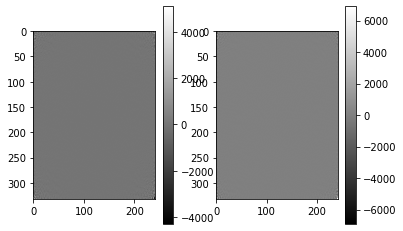

In [12]:
P = fft2(normalized_patch)
plt.subplot(121)
plt.imshow(np.real(P), cmap="gray")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.imag(P), cmap="gray")
plt.colorbar()

In [13]:
A = np.conjugate(C) * P
B = np.conjugate(P) * P

# MOSSE update rule
M = A / B

# NCC update rule
#M = P

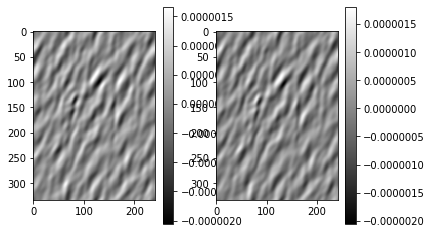

In [14]:
m = ifft2(M)
plt.subplot(121)
plt.imshow(np.real(m), cmap="gray")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.imag(m), cmap="gray")
plt.colorbar()

## Detect

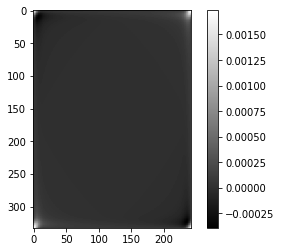

In [15]:
response = ifft2( np.conjugate(M) * P )
plt.imshow(np.real(response), cmap="gray")
plt.colorbar()

In [16]:
r, c = np.unravel_index(np.argmax(response), response.shape)

r_offset = np.mod(r + region_center[0], region.height) - region_center[0]
c_offset = np.mod(c + region_center[1], region.width) - region_center[1]

print(f"r_offset: {r_offset}\tc_offset: {c_offset}")

r_offset: 0	c_offset: 0


## Detect in next frame

Press CTRL+Enter to step through the frames

Frame: 25
y: 1	x:237
r_offset: 1	c_offset: -4


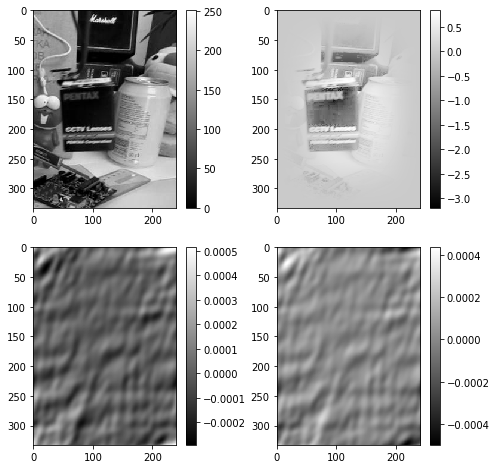

In [70]:
frame_idx += 1 
frame = next(a_seq)
image = np.sum(frame["image"], 2) / 3

plt.figure(figsize=(8, 8))

# Detect ---

patch = crop_patch(image, region)
plt.subplot(221)
plt.imshow(patch, cmap="gray")
plt.colorbar()

normalized_patch = MOSSETrackerGrayscale.normalize(patch)
plt.subplot(222)
plt.imshow(normalized_patch, cmap="gray")
plt.colorbar()

P = fft2(normalized_patch)
response = ifft2( np.conjugate(M) * P )
plt.subplot(223)
plt.imshow(np.real(response), cmap="gray")
plt.colorbar()
plt.subplot(224)
plt.imshow(np.imag(response), cmap="gray")
plt.colorbar()

r, c = np.unravel_index(np.argmax(response), response.shape)
r_offset = np.mod(r + region_center[0], region.height) - region_center[0]
c_offset = np.mod(c + region_center[1], region.width) - region_center[1]

print(f"Frame: {frame_idx}")
print(f"y: {r}\tx:{c}")
print(f"r_offset: {r_offset}\tc_offset: {c_offset}")

region.xpos += c_offset
region.ypos += r_offset

# Update --

patch = crop_patch(image, region)
normalized_patch = MOSSETrackerGrayscale.normalize(patch)
P = fft2(normalized_patch)

# MOSSE Update rule
A = A * (1-learning_rate) + np.conjugate(C) * P * learning_rate
B = B * (1-learning_rate) + np.conjugate(P) * P * learning_rate
M = A / B

# NCC Update rule
#M = M * (1-learning_rate) + P * learning_rate

## Multichannel MOSSE test

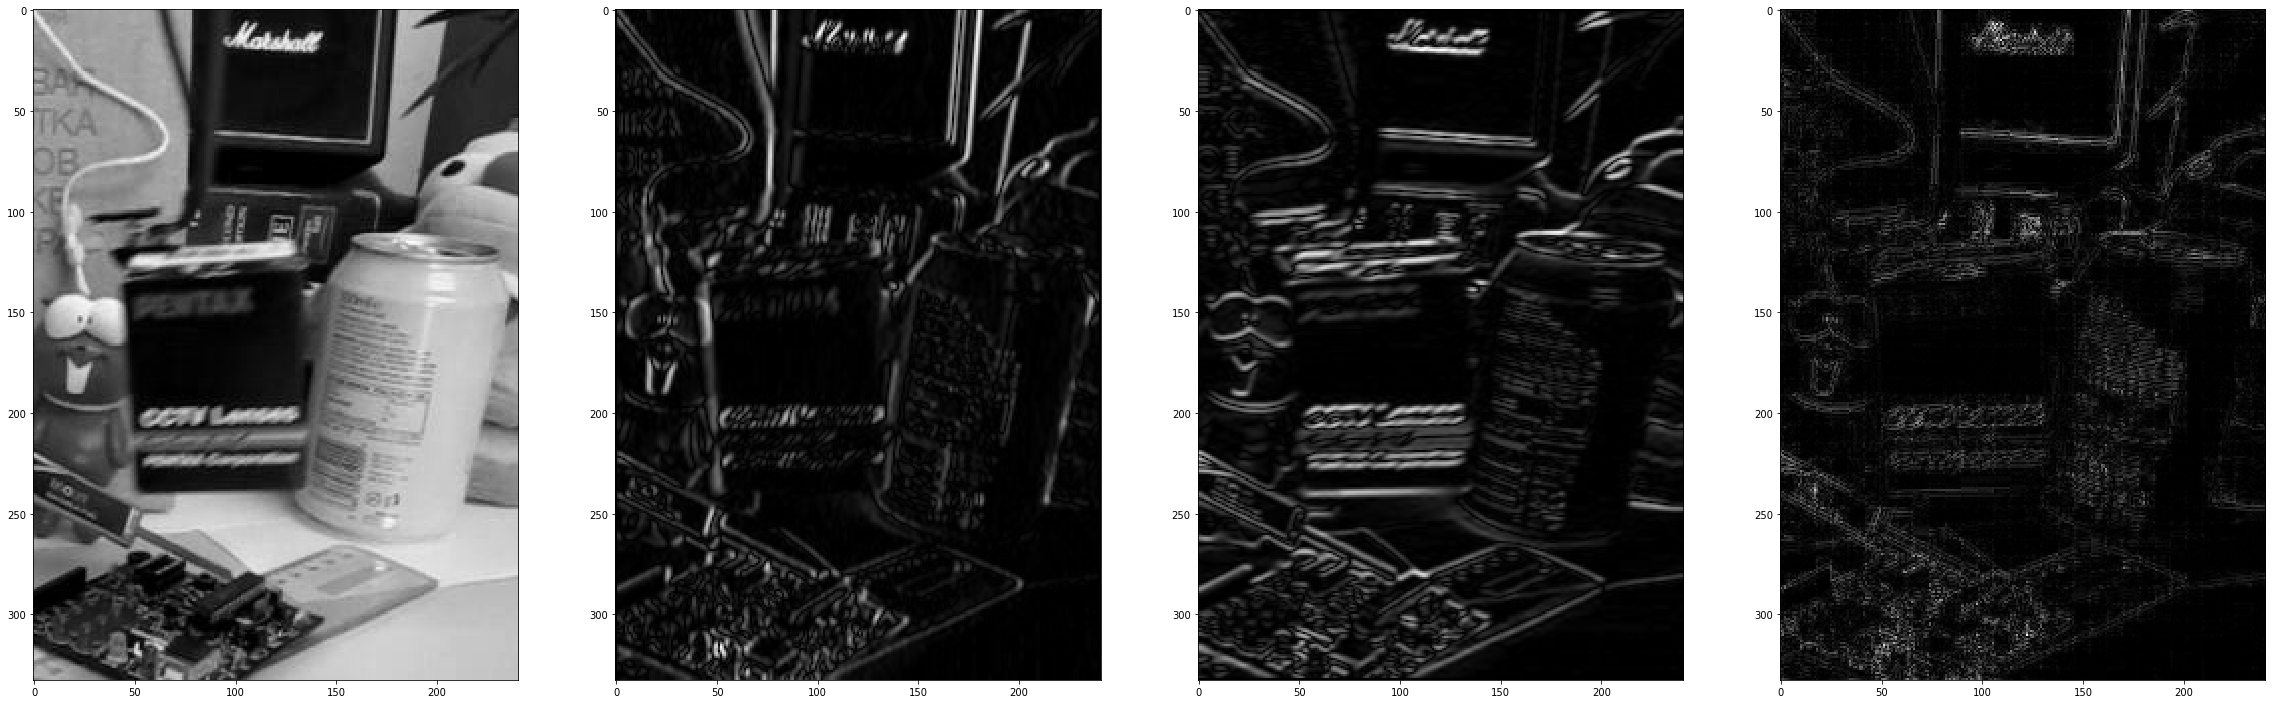

In [71]:
frame = next(a_seq)

tracker = MOSSEMultiChannel()
#image =  np.sum(frame["image"], 2) / 3
image = frame['image']
plt.figure(figsize=(40,40))

# Features

feat_descr = tracker.desc_patch_from_image(image, region)

plt.subplot(141)
plt.imshow(feat_descr[:,:,0], cmap="gray")
plt.subplot(142)
plt.imshow(feat_descr[:,:,1], cmap="gray")
plt.subplot(143)
plt.imshow(feat_descr[:,:,2], cmap="gray")
plt.subplot(144)
plt.imshow(feat_descr[:,:,3], cmap="gray")

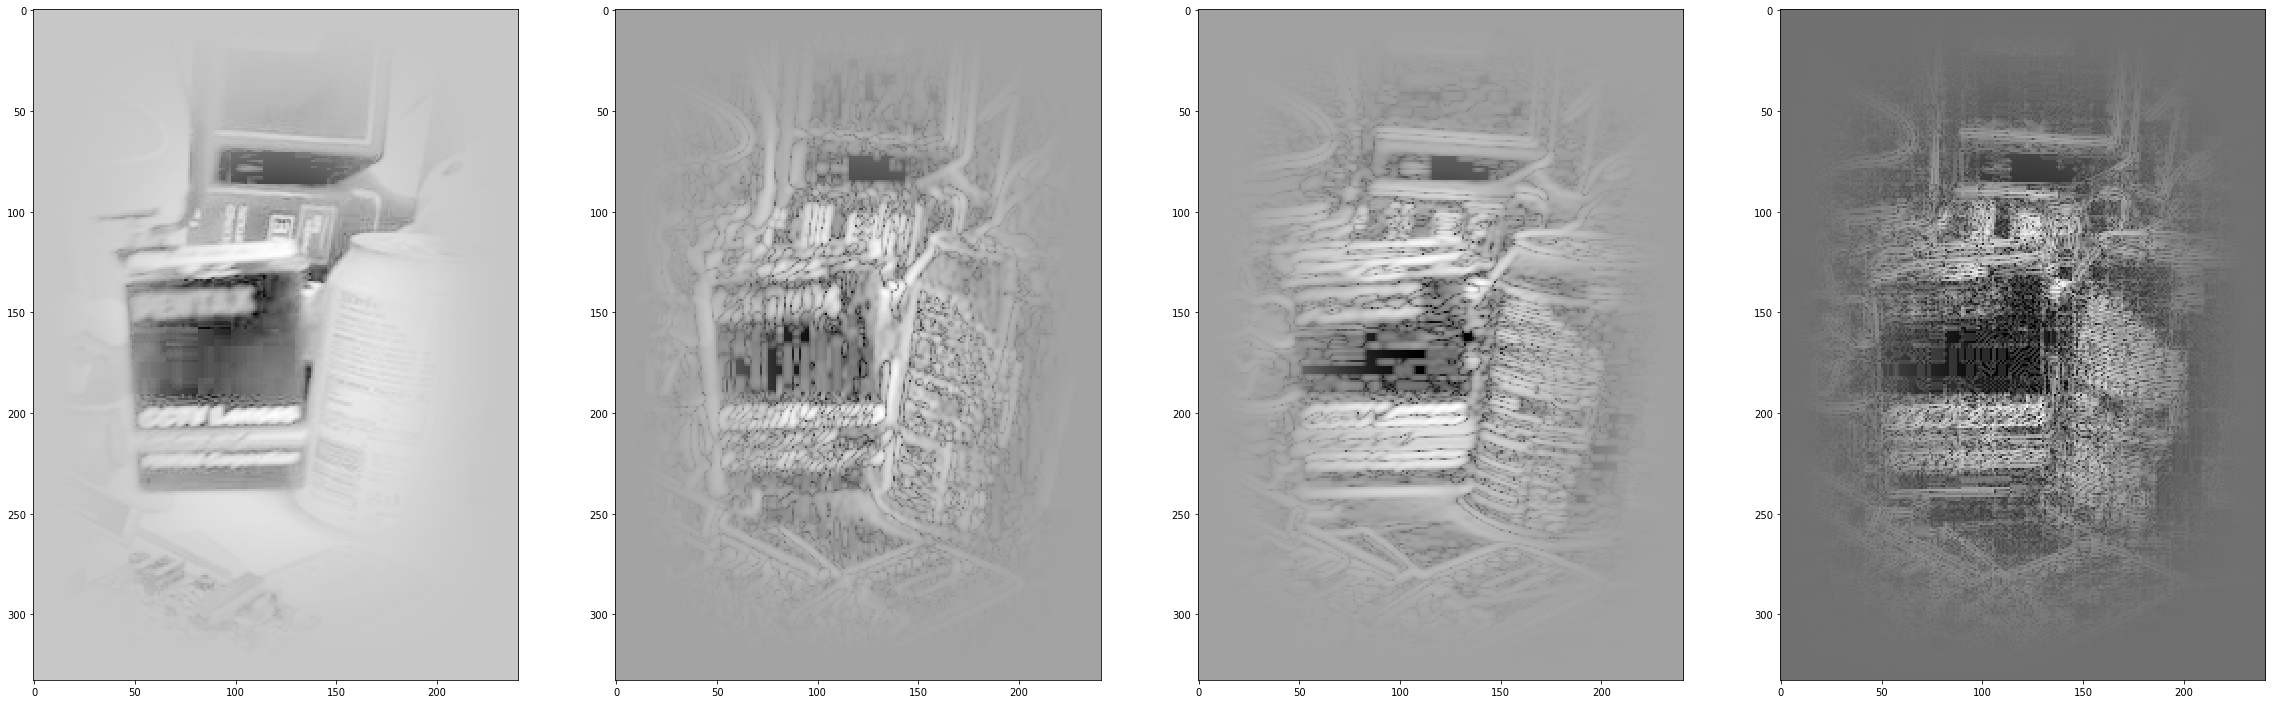

In [72]:
# Normalized features

plt.figure(figsize=(40,40))
plt.subplot(141)
plt.imshow(MOSSEMultiChannel.normalize(feat_descr[:,:,0]), cmap="gray")
plt.subplot(142)
plt.imshow(MOSSEMultiChannel.normalize(feat_descr[:,:,1]), cmap="gray")
plt.subplot(143)
plt.imshow(MOSSEMultiChannel.normalize(feat_descr[:,:,2]), cmap="gray")
plt.subplot(144)
plt.imshow(MOSSEMultiChannel.normalize(feat_descr[:,:,3]), cmap="gray")

In [59]:
# start

C = MOSSEMultiChannel.get_fourier_transformed_gaussian(height=region.height, width=region.width, std=std,
                                                                    mean_x=0, mean_y=0)
                                                                    
Ps = [fft2(MOSSEMultiChannel.normalize(feat_descr[:,:,i])) for i in range(4)]
As = [np.conjugate(C) * P for P in Ps]
B = np.sum([np.conjugate(P) * P for P in Ps], axis=0)
Ms = [A / B for A in As]

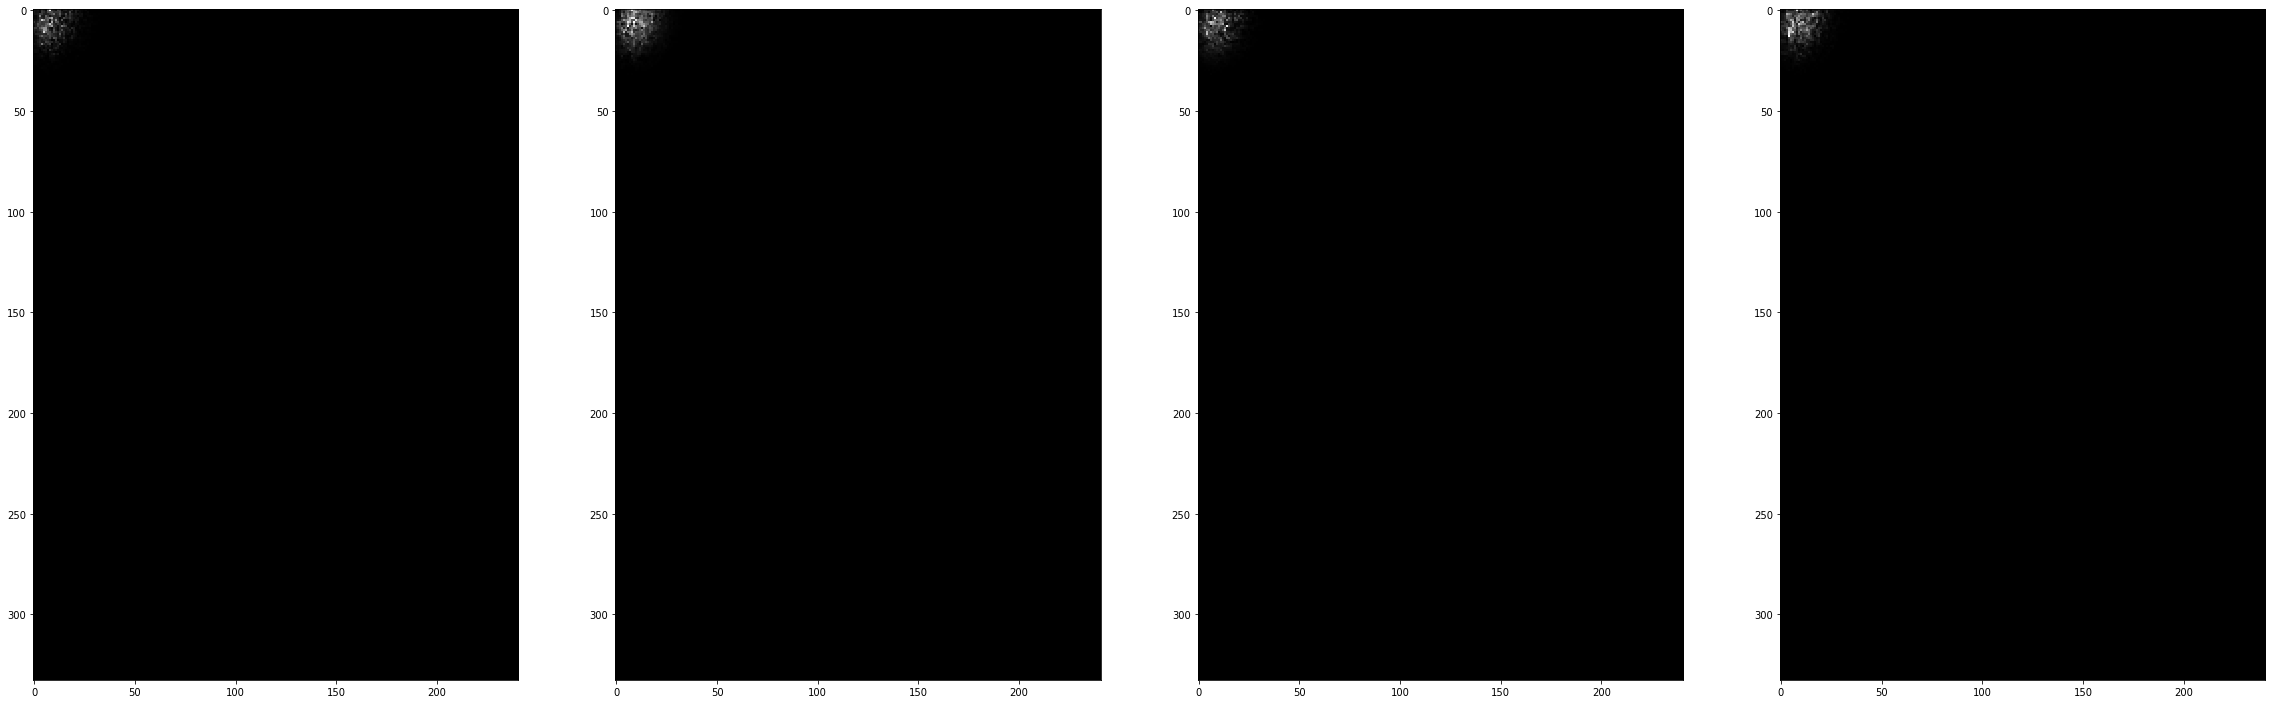

In [73]:
plt.figure(figsize=(40,40))
plt.subplot(141)
plt.imshow(np.abs(Ms[0]), cmap="gray")
plt.subplot(142)
plt.imshow(np.abs(Ms[1]), cmap="gray")
plt.subplot(143)
plt.imshow(np.abs(Ms[2]), cmap="gray")
plt.subplot(144)
plt.imshow(np.abs(Ms[3]), cmap="gray")

In [74]:
# detect 
frame_idx += 1 
frame = next(a_seq)

In [75]:
image = frame["image"]


feat_descr = tracker.desc_patch_from_image(image, region)
Ps = [fft2(MOSSEMultiChannel.normalize(feat_descr[:,:,i])) for i in range(4)]
        
responses = [ifft2(np.conjugate(M) * P) for M, P in zip(Ms, Ps)]
response = np.sum(responses, axis=0)

TypeError: Image data of dtype complex128 cannot be converted to float

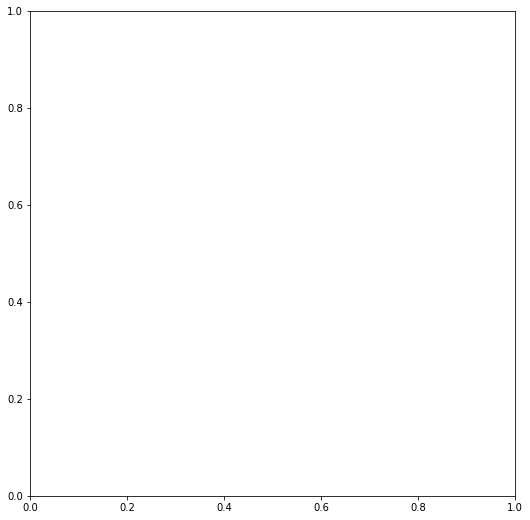

In [68]:
plt.figure(figsize=(40,40))
plt.subplot(141)
plt.imshow(response, cmap="gray")
#plt.subplot(142)
#plt.imshow(responses[1], cmap="gray")
#plt.subplot(143)
#plt.imshow(responses[2], cmap="gray")
#plt.subplot(144)
#plt.imshow(responses[3], cmap="gray")

In [79]:
responses

[array([[0.00024472-8.50220217e-05j, 0.0002542 -6.04427295e-05j,
         0.00025824-3.39669878e-05j, ..., 0.00019463-1.34480805e-04j,
         0.00021345-1.22836322e-04j, 0.00023068-1.06179676e-04j],
        [0.00025699-5.86359529e-05j, 0.00026295-3.30458472e-05j,
         0.00026327-6.34496272e-06j, ..., 0.00021453-1.14446307e-04j,
         0.00023142-1.00321911e-04j, 0.00024608-8.14789061e-05j],
        [0.00026483-3.00416874e-05j, 0.00026712-4.09401789e-06j,
         0.00026373+2.21579042e-05j, ..., 0.00023103-9.07091129e-05j,
         0.00024557-7.45023472e-05j, 0.0002573 -5.39767194e-05j],
        ...,
        [0.00018776-1.43970097e-04j, 0.00020573-1.25711342e-04j,
         0.00021957-1.03629775e-04j, ..., 0.00012363-1.68456334e-04j,
         0.0001451 -1.65509219e-04j, 0.00016701-1.57389537e-04j],
        [0.00020931-1.28225957e-04j, 0.00022491-1.07406083e-04j,
         0.00023584-8.33077813e-05j, ..., 0.00014823-1.61667324e-04j,
         0.00016936-1.55733645e-04j, 0.00019028-